In [1]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_context("notebook")
sns.set_style("dark")

In [4]:
use_example = False
if use_example:
    with open("example-real-data.json", "rb") as f:
        old_raw_data = json.load(f)
else:
    old_raw_data = {"data": []}
    files = os.listdir("./data/")
    for file in files:
        if file.endswith(".json"):
            with open(f"data/{file}", "r") as f:
                match_data = json.load(f)
                match_ts = file.replace(".json", "")
                if len(match_data["data"]) < 1000:
                    continue
                old_raw_data["data"] += [{**el, "match_ts": match_ts} for el in match_data["data"]]

In [5]:
len(old_raw_data["data"])

22896

## Loading raw data from analytics system

In [6]:
is_veteran_regex = r'\w+\-\w*V\w*'

In [7]:
show_outliers = False
share_x = 'all'

In [8]:
raw_data = []

for el in old_raw_data["data"]:
    # Value
    if "value" in el:
        el["value"] = float(el["value"])

    # Unique ts of match
    if "i" in el:
        el["i"] = el["i"] + "-" + el["match_ts"]
    if "t" in el:
        el["t"] = el["t"] + "-" + el["match_ts"]
    if "ips" in el:
        el["ips"] = el["ips"] + "-" + el["match_ts"]
    if "tps" in el:
        el["tps"] = el["tps"] + "-" + el["match_ts"]

    # Classes
    if "il" in el and "if" in el:
        el["i-faction-class"] = el["if"] + "-" + el["il"]
        el["i-is-veteran"] = bool(re.search(is_veteran_regex, el["i-faction-class"]))

    if "tl" in el and "tf" in el:
        el["t-faction-class"] = el["tf"] + "-" + el["tl"]
        el["t-is-veteran"] = bool(re.search(is_veteran_regex, el["t-faction-class"]))

    # Instigator coords
    if "ic" in el:
        el["ic_x"] = float(el["ic"].split(" ")[0].split("=")[1])
    if "ic" in el:
        el["ic_y"] = float(el["ic"].split(" ")[1].split("=")[1])

    # Target coords
    if "tc" in el:
        el["tc_x"] = float(el["tc"].split(" ")[0].split("=")[1])
    if "tc" in el:
        el["tc_y"] = float(el["tc"].split(" ")[1].split("=")[1])

    raw_data.append(el)

## Analyzing damage (per pawn, per class)

In [9]:
damage_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Damage"])
# Removing friendly fire when analyzing damage
damage_df = damage_df[damage_df["if"] != damage_df["tf"]]

In [10]:
# Leave only damage from characters to characters
damage_df = damage_df[damage_df['i'].str.startswith("CH_")]
damage_df = damage_df[damage_df['t'].str.startswith("CH_")]

In [11]:
damage_df.head()

,value,i,t,ips,tps,il,tl,if,tf,ic,...,Type,match_ts,i-faction-class,i-is-veteran,t-faction-class,t-is-veteran,ic_x,ic_y,tc_x,tc_y
0,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51079.837 Y=29148.345 Z=-4459.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51079.837,29148.345,56350.857,27681.017
1,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51046.594 Y=28667.714 Z=-5662.335,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51046.594,28667.714,55723.916,30893.533
2,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=51046.594 Y=28667.714 Z=-5662.335,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,51046.594,28667.714,55705.413,31008.169
3,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=54234.603 Y=29929.099 Z=-5612.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,54234.603,29929.099,56990.912,34883.034
4,20.0,CH_2147446280-2023-09-28T18-30-24.027793,CH_2147447461-2023-09-28T18-30-24.027793,PS_2147449614-2023-09-28T18-30-24.027793,PS_2147471837-2023-09-28T18-30-24.027793,HboS,TacS,CSM,LSM,X=54263.730 Y=29936.583 Z=-5612.713,...,Damage,2023-09-28T18-30-24.027793,CSM-HboS,False,LSM-TacS,False,54263.730,29936.583,56952.712,34906.876


In [12]:
# damage_df["value"] = pd.to_numeric(damage_df["value"])
damage_per_pawn = damage_df.groupby(["i"]).agg(
    damage_per_life=('value', 'sum'),
    loadout=('i-faction-class', 'first'),
    is_veteran=('i-is-veteran', 'first'),
    faction=('if', 'first')
)
damage_per_pawn.head()

,damage_per_life,loadout,is_veteran,faction
i,,,,
CH_2146995466-2023-09-28T20-10-31.299829,60.000000,LSM-SupS,False,LSM
CH_2146997203-2023-09-28T20-10-31.299829,290.120339,LSM-PcaS,False,LSM
CH_2146997980-2023-09-28T20-10-31.299829,235.500000,LSM-TacS,False,LSM
CH_2146998499-2023-09-28T20-10-31.299829,270.000000,CSM-JpaS,False,CSM
CH_2146999657-2023-09-28T20-10-31.299829,310.000000,LSM-SupS,False,LSM


In [13]:
damage_per_life_for_classes = damage_per_pawn.sort_values(by='loadout').groupby("loadout").agg(
    mean_damage_per_life=('damage_per_life', 'mean'),
    std_damage_per_life=('damage_per_life', 'std')
)
damage_per_life_for_classes

,mean_damage_per_life,std_damage_per_life
loadout,,
CSM-AucV,730.574596,442.655185
CSM-HboS,701.935118,764.134950
CSM-JpaS,638.181872,615.162968
CSM-JpaVA,534.174593,22.380505
CSM-MelS,310.403847,284.148975
CSM-MelV,1440.797400,NaN
CSM-PcaS,721.378380,713.670383
CSM-SupS,458.596030,473.732052
CSM-TacS,538.803990,546.735862


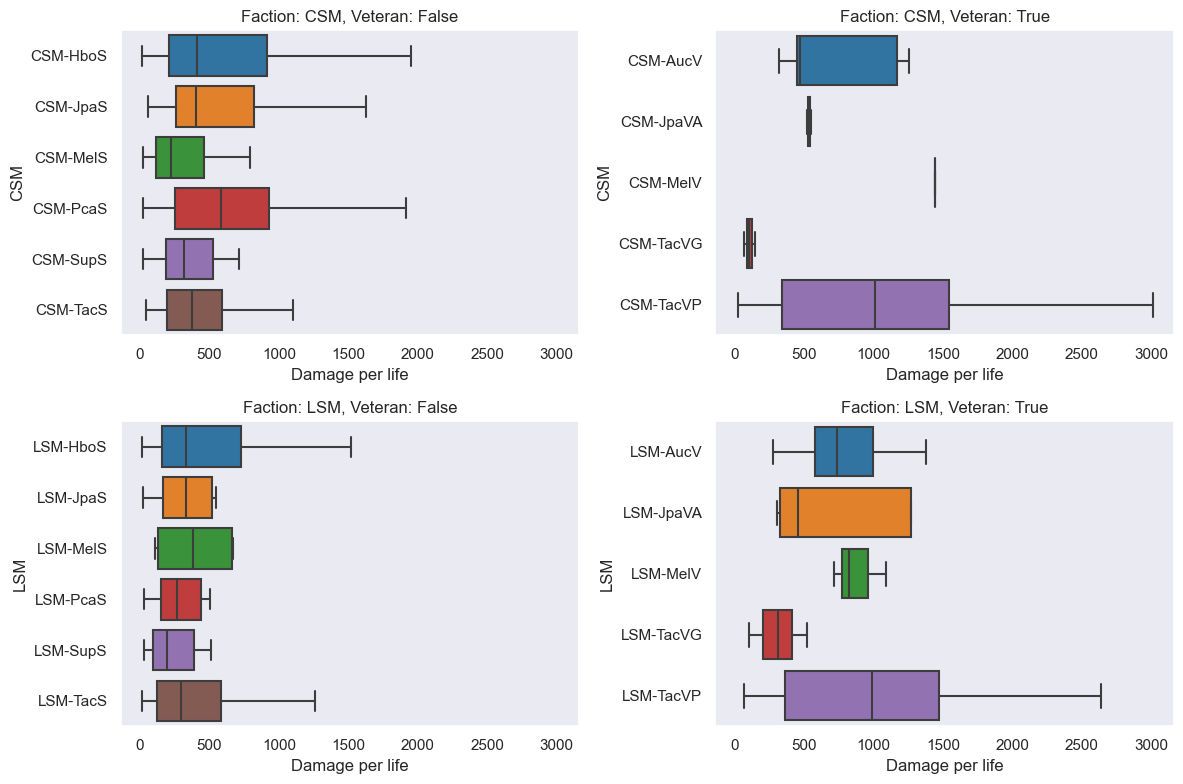

In [17]:
# Create a grid of subplots
fig, axes = plt.subplots(
    nrows=len(damage_per_pawn['faction'].unique()),
    ncols=len(damage_per_pawn['is_veteran'].unique()),
    figsize=(12, 8),
    sharex=share_x
)

# Grouping into subplots
for ((faction, veteran), subset), ax in zip(damage_per_pawn.groupby(['faction', 'is_veteran']), axes.flat):
    subset = subset.sort_values(by='loadout')  # Sort by 'loadout'
    sns.boxplot(x='damage_per_life', y='loadout', data=subset, ax=ax, orient='h', showfliers=show_outliers)

    # Set titles and axis labels
    ax.set_title(f'Faction: {faction}, Veteran: {veteran}')
    ax.set_xlabel('Damage per life')
    ax.set_ylabel(faction)

    # Set x-axis ticks for each subplot
    ax.tick_params(axis='x', labelbottom=True)

# Adjust layout
plt.tight_layout()
plt.show()

## Analyzing XP (per pawn, per class and action)

In [57]:
xp_df = pd.DataFrame([el for el in raw_data if el["Type"] == "XP"])
xp_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
0,CH_2147298023-2023-09-05T14-21-47.813736,-15.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4138.131 Y=-11216.999 Z=-355.835,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4138.131,-11216.999
1,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4376.996 Y=-11282.090 Z=-354.907,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4376.996,-11282.090
2,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.307 Y=-11435.213 Z=-337.219,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.307,-11435.213
3,CH_2147298023-2023-09-05T14-21-47.813736,-8.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=4614.654 Y=-11436.802 Z=-337.044,Friendly fire,XP,2023-09-05T14-21-47.813736,LSM-TacS,4614.654,-11436.802
4,CH_2147298354-2023-09-05T14-21-47.813736,50.0,PS_2147451513-2023-09-05T14-21-47.813736,LSM,MelS,X=4923.494 Y=-11255.877 Z=-338.951,Assist,XP,2023-09-05T14-21-47.813736,LSM-MelS,4923.494,-11255.877


In [67]:
xp_per_pawn_and_action = xp_df.groupby(["t", "action"]).agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn_and_action.head()

xp_per_life   loadout
t                                        action                               
CH_2146156837-2023-09-07T19-28-26.544644 Friendly fire         -87.0  LSM-HboS
CH_2146157199-2023-09-07T19-28-26.544644 Assist                 50.0  LSM-PcaS
                                         Enemy down            100.0  LSM-PcaS
                                         Enemy finished        100.0  LSM-PcaS
                                         Friendly fire         -20.0  LSM-PcaS

In [68]:
xp_per_pawn = xp_df.groupby("t").agg(
    xp_per_life=('value', 'sum'),
    loadout=('t-faction-class', 'first')
)
xp_per_pawn.head()

,xp_per_life,loadout
t,,
CH_2146156837-2023-09-07T19-28-26.544644,-87.0,LSM-HboS
CH_2146157199-2023-09-07T19-28-26.544644,230.0,LSM-PcaS
CH_2146157515-2023-09-07T19-28-26.544644,100.0,LSM-SupS
CH_2146165292-2023-09-07T19-28-26.544644,-34.0,LSM-PcaS
CH_2146165792-2023-09-07T19-28-26.544644,100.0,LSM-TacS


In [66]:
xp_per_life_for_class_and_action = xp_per_pawn_and_action.groupby(["loadout", "action"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class_and_action.head()

mean_xp_per_life  std_xp_per_life
loadout  action                                            
CSM-AucV Ally revived           150.000000              NaN
         Assist                 108.333333        58.452260
         Capture stopped        640.000000       536.656315
         Elite down             333.333333       230.940108
         Elite executed         300.000000              NaN

In [69]:
xp_per_life_for_class = xp_per_pawn.groupby(["loadout"]).agg(
    mean_xp_per_life=('xp_per_life', 'mean'),
    std_xp_per_life=('xp_per_life', 'std')
)
xp_per_life_for_class

,mean_xp_per_life,std_xp_per_life
loadout,,
CSM-AucV,927.916667,1381.065890
CSM-HboS,438.791367,599.851328
CSM-JpaS,424.096774,420.836338
CSM-JpaVA,697.750000,610.302443
CSM-MelS,546.520000,551.725909
CSM-MelV,616.500000,781.824033
CSM-PcaS,252.870968,544.016589
CSM-SupS,386.046512,567.983925
CSM-TacS,492.984520,686.353527


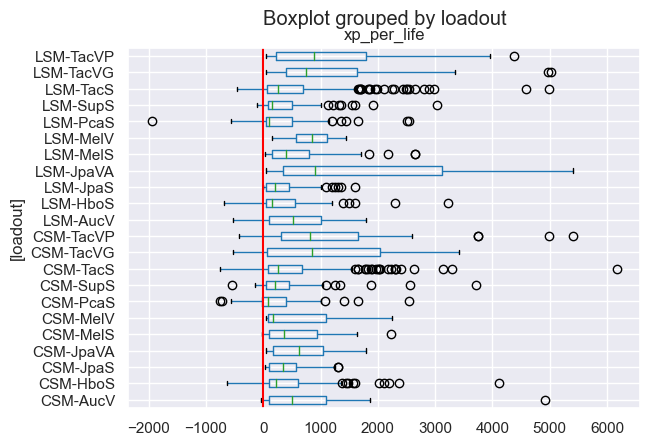

In [70]:
xp_per_pawn.sort_values(by='loadout').boxplot(by='loadout', vert=False)

plt.axvline(x=0, color='red')
plt.show()

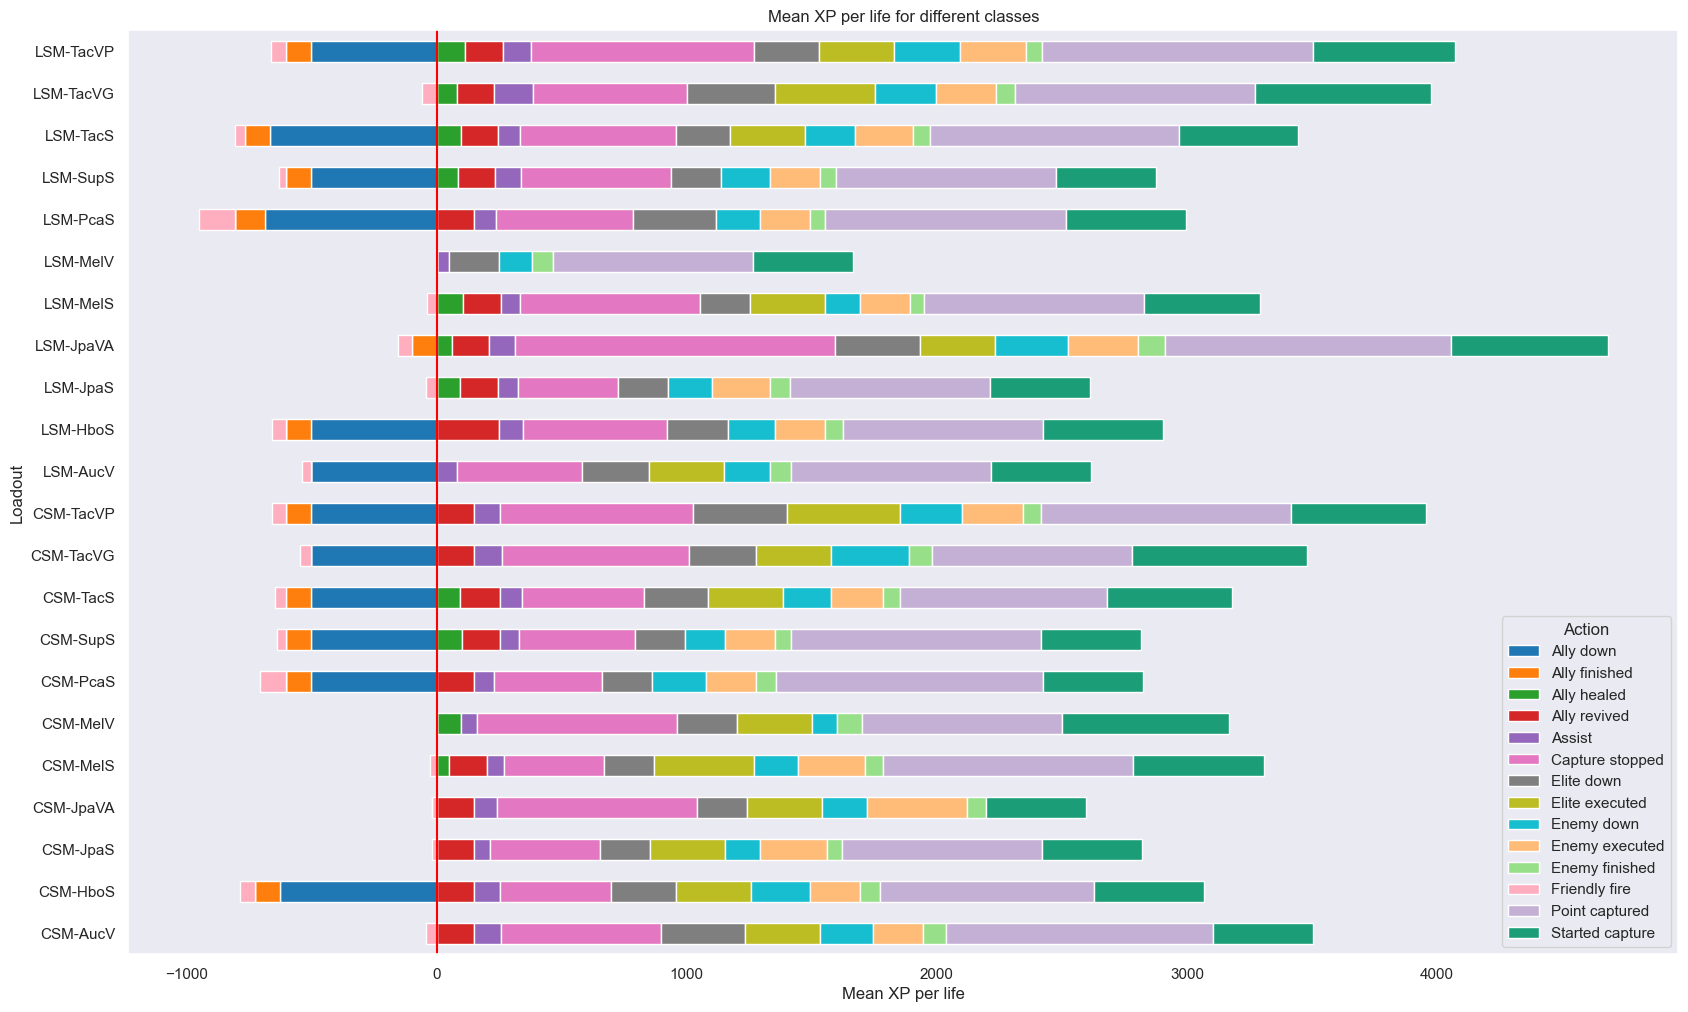

In [71]:
# Create a pivot table to reshape the data for plotting
pivot_xp_per_life_for_class_and_action = xp_per_life_for_class_and_action.reset_index()
pivot_xp_per_life_for_class_and_action = pivot_xp_per_life_for_class_and_action.pivot(index='loadout', columns='action',
                                                                                      values='mean_xp_per_life')

# Define a custom color palette
custom_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf',  # Cyan
    '#ffbb78',  # Light Orange
    '#98df8a',  # Light Green
    '#ffaec0',  # Light Pink
    '#c5b0d5',  # Light Purple
    '#1b9e77',  # Dark Green
]

# Create a rotated stacked barplot with the custom color palette
ax = pivot_xp_per_life_for_class_and_action.plot(kind='barh', stacked=True, figsize=(20, 12), color=custom_colors)

# Customize the plot
plt.title('Mean XP per life for different classes')
plt.xlabel('Mean XP per life')
plt.ylabel('Loadout')
plt.legend(title='Action')

plt.axvline(x=0, color='red')

# Show the plot
plt.show()

## Analyzing KD ratios

In [72]:
kills_df = xp_df[xp_df["action"] == "Enemy down"]
kills_df.head()

,t,value,tps,tf,tl,tc,action,Type,match_ts,t-faction-class,tc_x,tc_y
5,CH_2147298023-2023-09-05T14-21-47.813736,100.0,PS_2147480996-2023-09-05T14-21-47.813736,LSM,TacS,X=5075.189 Y=-11603.107 Z=-239.720,Enemy down,XP,2023-09-05T14-21-47.813736,LSM-TacS,5075.189,-11603.107
7,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4580.340 Y=-6189.420 Z=574.910,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4580.340,-6189.420
11,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=4736.840 Y=-3964.140 Z=561.360,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,4736.840,-3964.140
16,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3769.990 Y=-4582.180 Z=555.990,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3769.990,-4582.180
18,CH_2147299362-2023-09-05T14-21-47.813736,100.0,PS_2147478807-2023-09-05T14-21-47.813736,CSM,MelS,X=3640.960 Y=-3521.410 Z=559.720,Enemy down,XP,2023-09-05T14-21-47.813736,CSM-MelS,3640.960,-3521.410


In [73]:
kills_per_pawn = kills_df.groupby(["t"]).agg(
    kill_count=('t', 'count'),
    loadout=('t-faction-class', 'first')
)
kills_per_pawn.head()

,kill_count,loadout
t,,
CH_2146157199-2023-09-07T19-28-26.544644,1,LSM-PcaS
CH_2146157515-2023-09-07T19-28-26.544644,1,LSM-SupS
CH_2146165792-2023-09-07T19-28-26.544644,1,LSM-TacS
CH_2146168870-2023-09-07T19-28-26.544644,1,CSM-MelS
CH_2146173726-2023-09-07T19-28-26.544644,2,CSM-TacS


In [94]:
kills_per_life_for_classes = kills_per_pawn.groupby("loadout").agg(
    mean_kills_per_life=('kill_count', 'mean'),
    std_kills_per_life=('kill_count', 'std')
)
kills_per_life_for_classes

,mean_kills_per_life,std_kills_per_life
loadout,,
CSM-AucV,2.125000,2.031010
CSM-HboS,2.345238,1.978767
CSM-JpaS,1.375000,0.619139
CSM-JpaVA,1.800000,1.095445
CSM-MelS,1.750000,1.188715
CSM-MelV,1.000000,0.000000
CSM-PcaS,2.161290,1.968024
CSM-SupS,1.571429,0.948240
CSM-TacS,1.901235,1.596619


In [98]:
# kills_per_pawn.sort_values(by='loadout').boxplot(by="loadout", vert=False, bootstrap=1000)
# sns.violinplot(kills_per_pawn, x="kill_count", y="loadout")

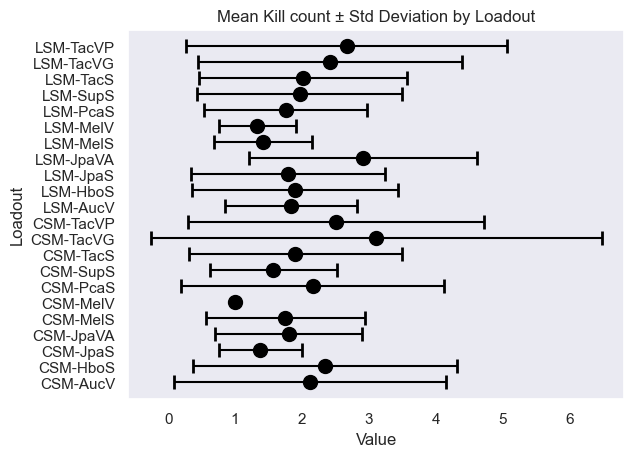

In [105]:
# Calculate mean and standard deviation
grouped = kills_per_pawn.groupby('loadout')['kill_count']
means = grouped.mean()
stds = grouped.std()

# Create a horizontal scatter plot for means
plt.scatter(means, means.index, color='black', label='Mean', s=100, marker='o')  # Adjust the 's' parameter for size

# Create vertical bars for standard deviation
for i, (mean_val, std_val) in enumerate(zip(means, stds)):
    plt.errorbar(mean_val, i, xerr=std_val, fmt='|', color='black', capsize=5, capthick=2, label='Std Deviation')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Loadout')
plt.title('Mean Kill count ± Std Deviation by Loadout')

plt.show()

## Analyzing class frequencies

In [100]:
spawn_df = pd.DataFrame([el for el in raw_data if el["Type"] == "Spawn"])

In [101]:
class_spawns = spawn_df["t-faction-class"].value_counts()

In [102]:
class_spawns.head()

t-faction-class
CSM-TacS    399
LSM-TacS    366
CSM-HboS    167
LSM-HboS    142
LSM-PcaS    123
Name: count, dtype: int64

<Axes: title={'center': 'Classes spawn frequency'}, ylabel='t-faction-class'>

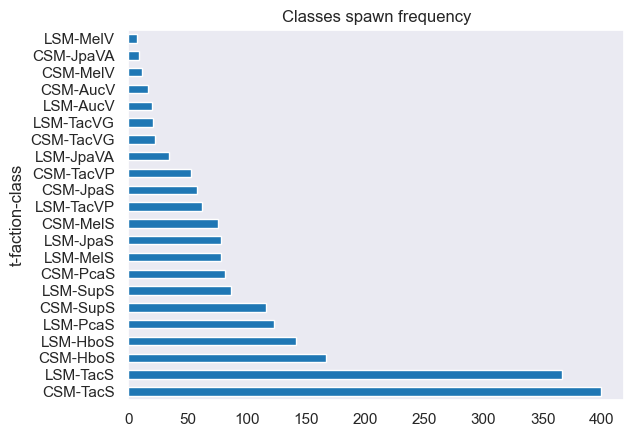

In [103]:
class_spawns.plot.barh(title="Classes spawn frequency")

## Heatmaps

### Damage dealers

In [68]:
x_points = list(damage_df["ic_x"])
y_points = list(damage_df["ic_y"])

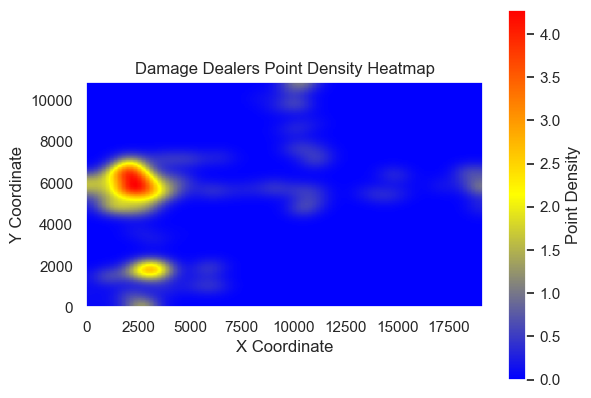

In [83]:
from matplotlib.colors import LinearSegmentedColormap

# Create a 2D histogram to represent point density
heatmap, xedges, yedges = np.histogram2d(x_points, y_points, bins=100)

# Smooth the heatmap using Gaussian convolution
from scipy.ndimage import gaussian_filter

heatmap = gaussian_filter(heatmap, sigma=3)

# Define a custom colormap (blue, yellow, red)
colors = [(0, 'blue'), (0.5, 'yellow'), (1, 'red')]
custom_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Create the heatmap plot
plt.imshow(heatmap.T, origin='lower', extent=[0, xedges.max(), 0, yedges.max()], cmap=custom_cmap)
plt.colorbar(label='Point Density')  # Add a colorbar for reference
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Damage Dealers Point Density Heatmap')

plt.show()